# Project_19 - Pytorch Classification (Moons)

## Project Description - Part 1
1. Create moons dataset using make_moons package in sklearn
2. Train a torch.nn model to classify the moons
3. Visualize the classification result

In [1]:
# Import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Setup device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42

In [3]:
n_samples = 1000
n_features = 2
n_class = 4

X, y = make_moons(n_samples=n_samples, random_state=RANDOM_SEED)
dataset = pd.DataFrame({'X1': X[:,0], 'X2':X[:,1], "label": y})
dataset.head()

,X1,X2,label
0,0.008727,0.368174,1
1,0.921384,-0.496905,1
2,0.940226,-0.498212,1
3,0.465875,-0.345406,1
4,-0.850412,0.526117,0


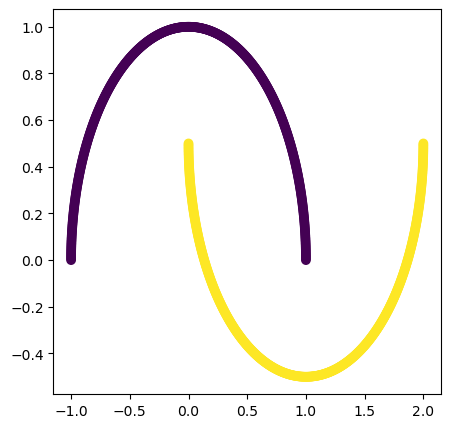

In [4]:
# Visualize the data on a scatter plot
plt.figure(figsize=(5,5))
plt.scatter(x=dataset['X1'], y=dataset['X2'], c=dataset['label'])
plt.show()

In [5]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [6]:
print(type(X), type(y))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [7]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
print(X_train.device, X_test.device, y_train.device, y_test.device)

cpu cpu cpu cpu


In [9]:
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
      z = self.layer_3(self.relu(self.layer_2(self.relu(self.layer_2(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))
      return z

In [10]:
model = MoonModelV0().to(device)
print(model)

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.01)

In [12]:
y_logits = model(X_train[:5])
print(f"Logits: {y_logits}")
print(f"Pred probs: {torch.sigmoid(y_logits)}")
print(f"Pred labels: {torch.round(torch.sigmoid(y_logits))}")

Logits: tensor([[0.0101],
        [0.0072],
        [0.0061],
        [0.0061],
        [0.0086]], grad_fn=<AddmmBackward0>)
Pred probs: tensor([[0.5025],
        [0.5018],
        [0.5015],
        [0.5015],
        [0.5021]], grad_fn=<SigmoidBackward0>)
Pred labels: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


In [13]:
torch.manual_seed(RANDOM_SEED)

epochs = 500
epoch_count = []
train_losses = []
test_losses = []

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_prob = torch.sigmoid(y_logits)
  y_pred = torch.round(y_prob)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_score(y_pred.detach().numpy(), y_train.detach().numpy()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_prob = torch.sigmoid(test_logits)
    test_pred = torch.round(test_prob)
    
    test_loss = loss_fn(test_pred, y_test)
    test_acc = accuracy_score(test_pred.detach().numpy(), y_test.detach().numpy())

    epoch_count.append(epoch)
    train_losses.append(loss.squeeze())
    test_losses.append(test_loss.squeeze())

  if epoch % 50 == 0:
    print(f'Epoch: {epoch} | Train_loss: {loss} | Train_acc: {acc} | Test_loss: {test_loss} | Test_acc: {test_acc}')


Epoch: 0 | Train_loss: 0.692558765411377 | Train_acc: 0.5 | Test_loss: 0.6931471824645996 | Test_acc: 0.5
Epoch: 50 | Train_loss: 0.30284035205841064 | Train_acc: 0.89375 | Test_loss: 0.5532044172286987 | Test_acc: 0.9
Epoch: 100 | Train_loss: 0.09767664223909378 | Train_acc: 0.96 | Test_loss: 0.5275061726570129 | Test_acc: 0.955
Epoch: 150 | Train_loss: 0.0004941378720104694 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc: 1.0
Epoch: 200 | Train_loss: 0.00019083610095549375 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc: 1.0
Epoch: 250 | Train_loss: 0.00011795017053373158 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc: 1.0
Epoch: 300 | Train_loss: 8.183139289030805e-05 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc: 1.0
Epoch: 350 | Train_loss: 6.062877218937501e-05 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc: 1.0
Epoch: 400 | Train_loss: 4.689002889790572e-05 | Train_acc: 1.0 | Test_loss: 0.5032044053077698 | Test_acc

In [14]:
def plot_decision_boundary(model, X, y):

    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

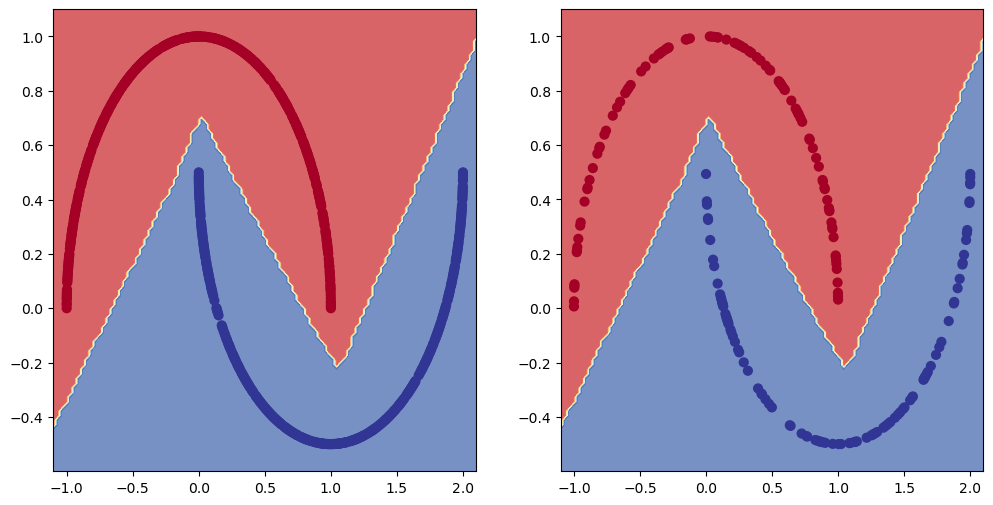

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model, X_test, y_test)

## Project Description - Part 2
1. Create spiral dataset using nump7
2. Train a torch.nn model to classify the spiral data
3. Visualize the classification result

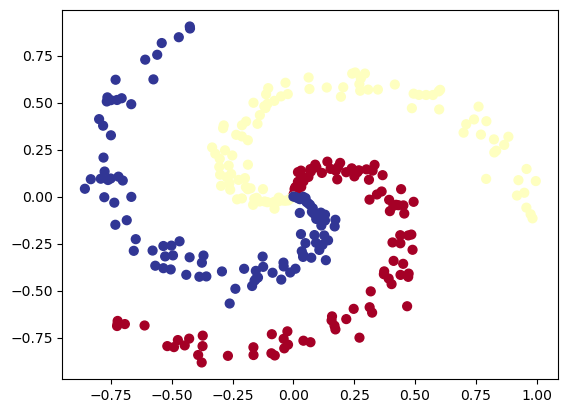

In [16]:
# Code for creating a spiral dataset from CS231n
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100   # number of points per class
D = 2   # dimensionality
K = 3   # number of classes
X = np.zeros((N*K,D))   # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8')   # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [17]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [18]:
print(X[:5], y[:5])

tensor([[0.0000, 0.0000],
        [0.0001, 0.0101],
        [0.0042, 0.0198],
        [0.0125, 0.0276],
        [0.0046, 0.0401]]) tensor([0, 0, 0, 0, 0])


In [19]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
print(X_train.shape, y_train.shape)

torch.Size([240, 2]) torch.Size([240])


In [21]:
# Prepare device agnostic code
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [22]:
# Create model by subclassing nn.Module
# model_01 = nn.Sequential(
#     nn.Linear(2, 40),
#     nn.ReLU(),
#     nn.Linear(40, 40),
#     nn.ReLU(),
#     nn.Linear(40, 20),
#     nn.ReLU(),
#     nn.Linear(20, 3),
# )

# model_01.to(device)
# model_01

In [23]:
# Create model by subclassing nn.Module
class SpiralModel01(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=40)
    self.layer_2 = nn.Linear(in_features=40, out_features=40)
    self.layer_3 = nn.Linear(in_features=40, out_features=20)
    self.layer_4 = nn.Linear(in_features=20, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
      z = self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))
      return z

In [24]:
model_01 = SpiralModel01().to(device)
print(model_01)

SpiralModel01(
  (layer_1): Linear(in_features=2, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=40, bias=True)
  (layer_3): Linear(in_features=40, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=3, bias=True)
  (relu): ReLU()
)


In [25]:
# Setup data to be device agnostic
# Print out first 10 untrained model outputs (forward pass)
y_logits = model_01(X_train[:5])
print(f"Logits: {y_logits}")

y_prob = torch.softmax(y_logits, dim=1)
print(f"Pred probs: {y_prob}")

y_pred = torch.argmax(y_prob, dim=1)
print(f"Pred labels: {y_pred}")

Logits: tensor([[-0.0428, -0.0246,  0.1516],
        [-0.0494, -0.0283,  0.1451],
        [-0.0425, -0.0278,  0.1576],
        [-0.0539, -0.0318,  0.1528],
        [-0.0484, -0.0321,  0.1577]], grad_fn=<AddmmBackward0>)
Pred probs: tensor([[0.3093, 0.3150, 0.3757],
        [0.3090, 0.3156, 0.3754],
        [0.3090, 0.3136, 0.3775],
        [0.3075, 0.3144, 0.3781],
        [0.3081, 0.3132, 0.3787]], grad_fn=<SoftmaxBackward0>)
Pred labels: tensor([2, 2, 2, 2, 2])


In [26]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_01.parameters(), lr=0.001)

In [27]:
# Build a training loop for the model
epochs = 300
epoch_count = []
train_losses = []
test_losses = []

for epoch in range(epochs):
  model.train()
  y_logits = model_01(X_train).squeeze()
  y_prob = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_prob, dim=1)

  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_score(y_pred.detach().numpy(), y_train.detach().numpy())

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_01.eval()
  with torch.inference_mode():
    test_logits = model_01(X_test).squeeze()
    test_prob = torch.softmax(test_logits, dim=1)
    test_pred = torch.argmax(test_prob, dim=1)
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_score(test_pred.detach().numpy(), y_test.detach().numpy())

    epoch_count.append(epoch)
    train_losses.append(train_loss.detach().numpy())
    test_losses.append(test_loss.detach().numpy())
    
  if epoch % 20 == 0:
    print(f'Epoch: {epoch} | Train_loss: {loss:.4} | Train_acc: {acc:.4} | Test_loss: {test_loss:.4} | Test_acc: {test_acc:.4}')

Epoch: 0 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 1.097 | Test_acc: 0.3667
Epoch: 20 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 1.083 | Test_acc: 0.5
Epoch: 40 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 1.046 | Test_acc: 0.6
Epoch: 60 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.9747 | Test_acc: 0.6167
Epoch: 80 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.8043 | Test_acc: 0.5667
Epoch: 100 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.5867 | Test_acc: 0.6167
Epoch: 120 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.3983 | Test_acc: 0.8167
Epoch: 140 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.2421 | Test_acc: 0.9
Epoch: 160 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.1465 | Test_acc: 0.9833
Epoch: 180 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.09311 | Test_acc: 1.0
Epoch: 200 | Train_loss: 3.065e-05 | Train_acc: 1.0 | Test_loss: 0.06356 | Test_acc: 1.0
Epoch: 220 | Train_lo

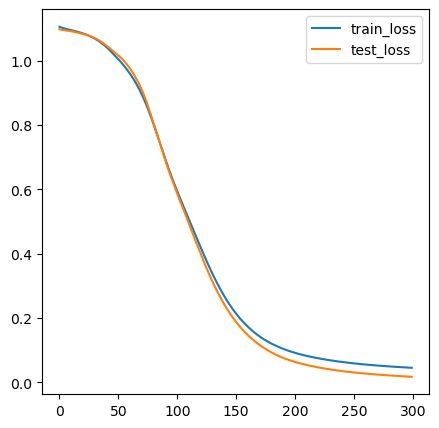

In [28]:
plt.figure(figsize=(5,5))
plt.plot(epoch_count, train_losses, label='train_loss')
plt.plot(epoch_count, test_losses, label='test_loss')
plt.legend()
plt.show()

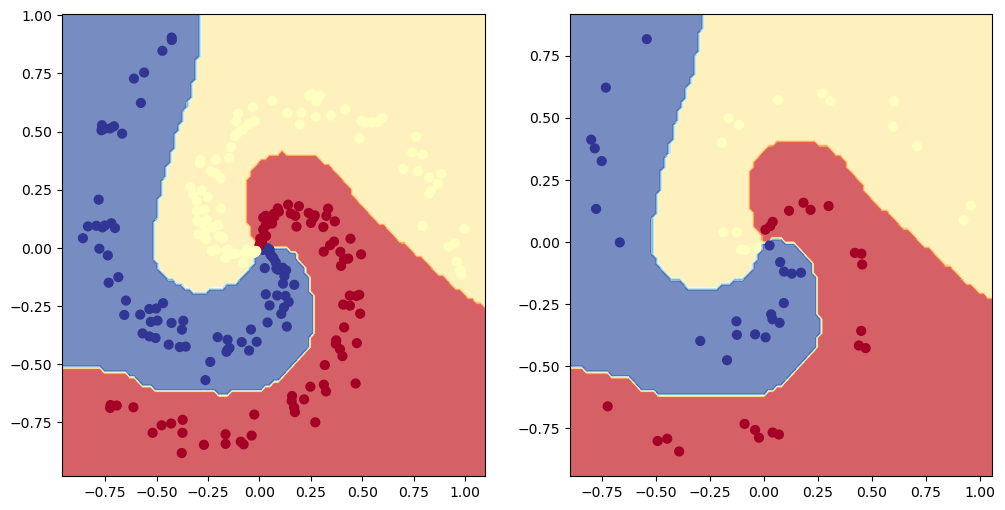

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_01, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model_01, X_test, y_test)